In [1]:
import numpy
import random
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from PIL import Image
import pandas
from sklearn.linear_model import LinearRegression, LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import scipy
from scipy import stats
from scipy.stats import poisson, ttest_ind
from scipy import linalg
import xarray as xr
import netCDF4
import cftime
import readline
import os

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/apps/opt/conda/envs/npl-2022b/share/proj failed


In [2]:
# Open File
File = '/glade/u/home/whimkao//ExtraTrack/ExTraTrack/et-tracker/zarzycki2017_data/traj_et_era_avg'
Data = open(File, 'r')
Rows = []
#
# Organize Data
for Line in Data:
    Rows.append(Line.strip())
#print (len(Rows[1]))
#print (len(Rows[38]))
print (Rows[38][0:7])

-103.36


In [3]:
# Organize Data Into Dictionary Containing Arrays
Storm_Code = []
Storm_List = []
for i in range(len(Rows)):
    if Rows[i][0:5] == 'start':
        Code = Rows[i][41:45]
        Storm_List.append(Code)
    else:
        Storm_Code.append(Code)
Array = numpy.zeros((13, len(Rows)-len(Storm_List)))
Time = []
k = -1
for i in range(len(Rows)):
    if Rows[i][0:5] == 'start':
        k += 1
    else:
        l = len(Rows[i]) - 100
        Array[0][i-k-1] = float(Rows[i][0:6+l])
        Array[1][i-k-1] = float(Rows[i][9+l:14+l])
        Array[2][i-k-1] = float(Rows[i][17+l:24+l])
        Array[3][i-k-1] = float(Rows[i][27+l:31+l])
        Array[4][i-k-1] = float(Rows[i][34+l:41+l])
        Array[5][i-k-1] = float(Rows[i][44+l:51+l])
        Array[6][i-k-1] = float(Rows[i][54+l:61+l])
        Array[7][i-k-1] = float(Rows[i][64+l:71+l])
        Array[8][i-k-1] = float(Rows[i][74+l:81+l])
        Time.append(datetime.datetime(year=int(Rows[i][84+l:88+l]), month=int(Rows[i][90+l:92+l]), \
        day=int(Rows[i][94+l:96+l]), hour=int(Rows[i][98+l:100+l])))
#print (len(Array[0]))
#print (len(Time))
#        Array[9][i-k-1] = int(Rows[i][84:88])
#        Array[10][i-k-1] = int(Rows[i][90:92])
#        Array[11][i-k-1] = int(Rows[i][94:96])
#        Array[12][i-k-1] = int(Rows[i][98:100])
#        print (Rows[i])
#        print (float(Rows[i][9:14]))
#        print (Rows[i][17])
#print (Array)
#
# Create DataFrame to Store Data
DF = pandas.DataFrame({"Code": Storm_Code, "Lon": Array[0], "Lat": Array[1], "SLP(hPa)": Array[2], \
"Winds(m/s)": Array[3], "Dist(m)": Array[4], "Angle": Array[5], "B": Array[6], "VLT": Array[7], "VUT": Array[8], \
"Time(Z)": Time})
DF

,Code,Lon,Lat,SLP(hPa),Winds(m/s),Dist(m),Angle,B,VLT,VUT,Time(Z)
0,0001,-59.06,12.98,1006.42,11.8,152.38,270.00,-4.51,3.87,49.37,1980-08-04 00:00:00
1,0001,-60.47,12.98,1005.52,12.7,152.38,270.00,-4.06,4.39,53.04,1980-08-04 06:00:00
2,0001,-62.58,14.39,1006.12,15.3,276.21,304.56,-4.44,-2.48,59.19,1980-08-04 12:00:00
3,0001,-64.69,14.39,1004.47,14.8,227.20,270.00,-5.56,-2.49,64.16,1980-08-04 18:00:00
4,0001,-67.50,15.09,1003.41,15.8,312.36,284.51,-6.11,-2.98,67.49,1980-08-05 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2779,0135,-49.22,36.14,1005.24,14.6,323.81,103.85,28.70,-104.98,-173.87,2002-10-16 06:00:00
2780,0135,-46.41,36.14,1007.32,20.3,252.56,90.00,26.01,-103.07,-163.51,2002-10-16 12:00:00
2781,0135,-44.30,35.44,1004.96,21.5,205.64,112.16,22.16,-98.91,-147.28,2002-10-16 18:00:00
2782,0135,-42.89,34.74,1006.77,19.4,149.87,121.20,20.14,-97.69,-138.68,2002-10-17 00:00:00


In [4]:
# Define Cyclone Type
Cyclone_Type = []
Plot_Shape = []
for i in range(len(Storm_List)):
    DF_Storm = DF[DF['Code'] == Storm_List[i]]
    for j in range(len(DF_Storm)):
        if j != 0:
            if numpy.array(DF_Storm['B'])[j] < 15 and numpy.array(DF_Storm['VLT'])[j] > 0:
                Cyclone_Type.append("Tropical")
                Plot_Shape.append("o")
            elif numpy.array(DF_Storm['B'])[j] > 15 and numpy.array(DF_Storm['VLT'])[j] < 0:
                Cyclone_Type.append("Extratropical")
                Plot_Shape.append("^")
            else:
                Cyclone_Type.append("Transition")
                Plot_Shape.append("s")
        else:
            if numpy.array(DF_Storm['B'])[j+1] < 15 and numpy.array(DF_Storm['VLT'])[j+1] > 0:
                Cyclone_Type.append("Tropical")
                Plot_Shape.append("o")
            elif numpy.array(DF_Storm['B'])[j+1] > 15 and numpy.array(DF_Storm['VLT'])[j+1] < 0:
                Cyclone_Type.append("Extratropical")
                Plot_Shape.append("^")
            else:
                Cyclone_Type.append("Transition")
                Plot_Shape.append("s")
#print (Plot_Shape)
DF["Type"] = Cyclone_Type
DF["Shape"] = Plot_Shape
DF

,Code,Lon,Lat,SLP(hPa),Winds(m/s),Dist(m),Angle,B,VLT,VUT,Time(Z),Type,Shape
0,0001,-59.06,12.98,1006.42,11.8,152.38,270.00,-4.51,3.87,49.37,1980-08-04 00:00:00,Tropical,o
1,0001,-60.47,12.98,1005.52,12.7,152.38,270.00,-4.06,4.39,53.04,1980-08-04 06:00:00,Tropical,o
2,0001,-62.58,14.39,1006.12,15.3,276.21,304.56,-4.44,-2.48,59.19,1980-08-04 12:00:00,Transition,s
3,0001,-64.69,14.39,1004.47,14.8,227.20,270.00,-5.56,-2.49,64.16,1980-08-04 18:00:00,Transition,s
4,0001,-67.50,15.09,1003.41,15.8,312.36,284.51,-6.11,-2.98,67.49,1980-08-05 00:00:00,Transition,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,0135,-49.22,36.14,1005.24,14.6,323.81,103.85,28.70,-104.98,-173.87,2002-10-16 06:00:00,Extratropical,^
2780,0135,-46.41,36.14,1007.32,20.3,252.56,90.00,26.01,-103.07,-163.51,2002-10-16 12:00:00,Extratropical,^
2781,0135,-44.30,35.44,1004.96,21.5,205.64,112.16,22.16,-98.91,-147.28,2002-10-16 18:00:00,Extratropical,^
2782,0135,-42.89,34.74,1006.77,19.4,149.87,121.20,20.14,-97.69,-138.68,2002-10-17 00:00:00,Extratropical,^


In [5]:
# SLP Colour Code
Colours = ['black', 'mediumblue', 'cyan', 'darkgreen', 'limegreen', 'gold', 'darkorange', 'red', 'darkviolet']
Colour_Labels = ['>=1010hPa', '1005-1010hPa', '1000-1005hPa', '990-1000hPa', '980-990hPa', \
'970-980hPa', '960-970hPa', '950-960hPa', '<950hPa']
Plot_Colour = []
for i in range(len(DF['SLP(hPa)'])):
        if DF['SLP(hPa)'][i] >= 1010:
            Plot_Colour.append(Colours[0])
        elif DF['SLP(hPa)'][i] >= 1005:
            Plot_Colour.append(Colours[1])
        elif DF['SLP(hPa)'][i] >= 1000:
            Plot_Colour.append(Colours[2])
        elif DF['SLP(hPa)'][i] >= 990:
            Plot_Colour.append(Colours[3])
        elif DF['SLP(hPa)'][i] >= 980:
            Plot_Colour.append(Colours[4])
        elif DF['SLP(hPa)'][i] >= 970:
            Plot_Colour.append(Colours[5])
        elif DF['SLP(hPa)'][i] >= 960:
            Plot_Colour.append(Colours[6])
        elif DF['SLP(hPa)'][i] >= 950:
            Plot_Colour.append(Colours[7])
        else:
            Plot_Colour.append(Colours[8])
#print (Plot_Colour)
DF["Colour"] = Plot_Colour

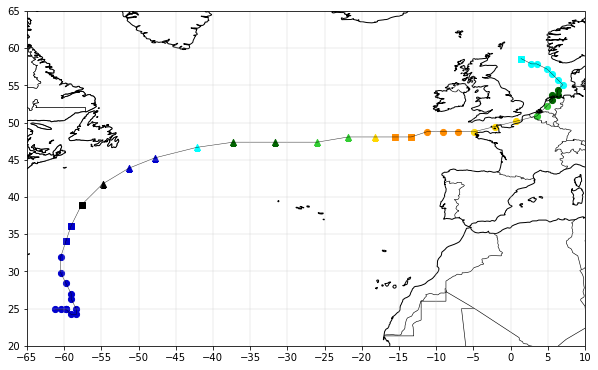

In [6]:
# Plot Cyclone Track
def Plot_Cyclone_Track(Storm_Code, DF):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    Lon = numpy.array(DF_Storm['Lon'])
    Lat = numpy.array(DF_Storm['Lat'])
    Plot_Colour = list(DF_Storm['Colour'])
    Plot_Shape = list(DF_Storm['Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=(10,10))
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.6)
    Axis.add_feature(cfeature.STATES, linewidth=0.5)
    Axis.plot(Lon, Lat, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Lon)):
        pyplot.scatter(Lon[k], Lat[k], c=Plot_Colour[k], marker=Plot_Shape[k], s=38)
#
# Formatting
    x_Min = (int(round(numpy.min(Lon) / 5)) - 1) * 5
    x_Max = (int(round(numpy.max(Lon) / 5)) + 1) * 5
    y_Min = (int(round(numpy.min(Lat) / 5)) - 1) * 5
    y_Max = (int(round(numpy.max(Lat) / 5)) + 1) * 5
    x_Axis = numpy.arange(x_Min,x_Max+5,5)
    y_Axis = numpy.arange(y_Min,y_Max+5,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
Plot_Cyclone_Track(Storm_List[41], DF)

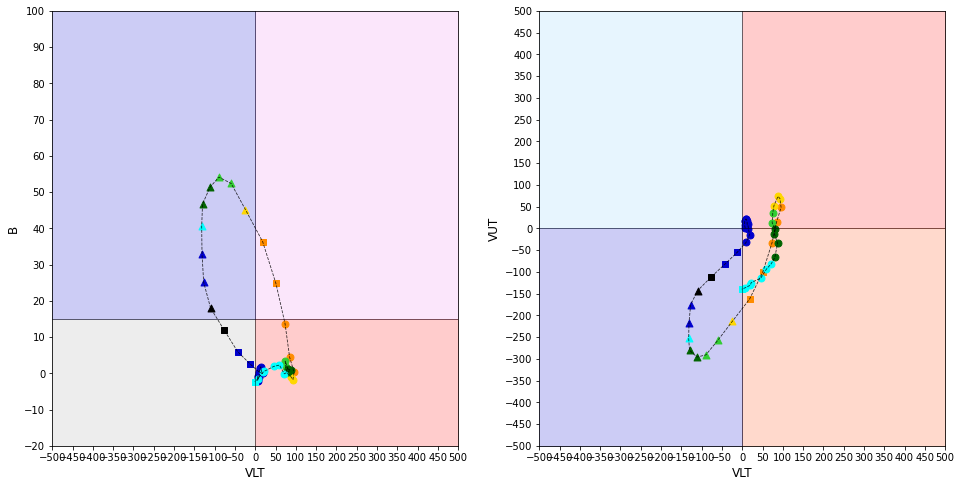

In [69]:
# Plot Cyclone Phase Diagram
def Plot_Cyclone_Phase(Storm_Code, DF):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    VLT = numpy.array(DF_Storm['VLT'])[1:]
    VUT = numpy.array(DF_Storm['VUT'])[1:]
    B = numpy.array(DF_Storm['B'])[1:]
    Plot_Colour = list(DF_Storm['Colour'])[1:]
    Plot_Shape = list(DF_Storm['Shape'])[1:]
#
# Plotting VUT VLT
    Fig = pyplot.figure(figsize=(16,8))
    Axis = Fig.add_subplot(1,2,1)
    x_Axis = numpy.arange(-500,600,100)
    y_Axis = numpy.arange(-20,110,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-20,100)
    pyplot.fill_between([0,500], 15, 100, color='violet', alpha=0.2)
    pyplot.fill_between([-500,0], 15, 100, color='mediumblue', alpha=0.2)
    pyplot.fill_between([0,500], -20, 15, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], -20, 15, color='darkgrey', alpha=0.2)
    pyplot.plot([-500,500], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-20,120], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    Axis.plot(VLT, B, c='black', linestyle='--', linewidth=0.8, alpha=0.8)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], B[k], c=Plot_Colour[k], marker=Plot_Shape[k], s=48)
#
# Plotting VUT VLT
    Axis = Fig.add_subplot(1,2,2)
    x_Axis = numpy.arange(-500,600,100)
    y_Axis = numpy.arange(-500,600,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-500,500)
    pyplot.fill_between([0,500], 500, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], 500, color='lightskyblue', alpha=0.2)
    pyplot.fill_between([0,500], -500, color='orangered', alpha=0.2)
    pyplot.fill_between([-500,0], -500, color='mediumblue', alpha=0.2)
    pyplot.plot([-500,500], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-500,500], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    Axis.plot(VLT, VUT, c='black', linestyle='--', linewidth=0.8, alpha=0.8)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], VUT[k], c=Plot_Colour[k], marker=Plot_Shape[k], s=48)
Plot_Cyclone_Phase(Storm_List[41], DF)

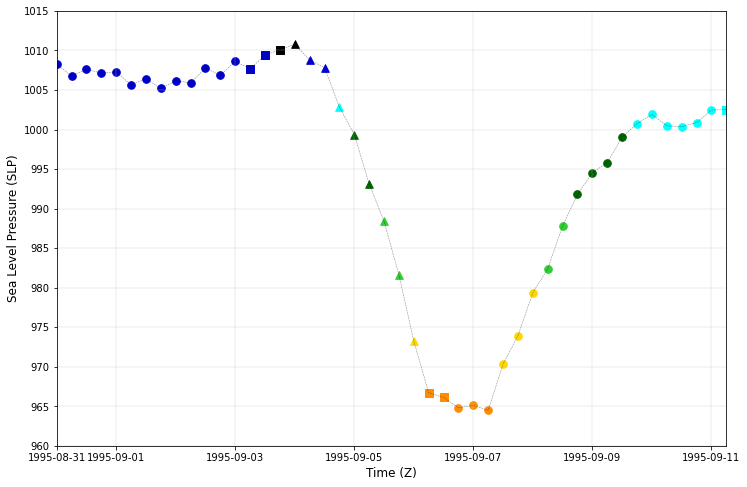

In [8]:
# Plot Cyclone SLP
def Plot_Cyclone_SLP(Storm_Code, DF):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    Time = list(DF_Storm['Time(Z)'])
    SLP = numpy.array(DF_Storm['SLP(hPa)'])
    Plot_Colour = list(DF_Storm['Colour'])
    Plot_Shape = list(DF_Storm['Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=(12,8))
    Axis = Fig.add_subplot(1,1,1)
    Axis.plot(Time, SLP, c='black', linestyle='--', linewidth=0.5, alpha=0.5)
    for k in range(len(Time)):
        Axis.scatter(Time[k], SLP[k], c=Plot_Colour[k], marker=Plot_Shape[k], s=58)
#
# Formatting
    pyplot.xlabel('Time (Z)', fontsize=12)
    pyplot.ylabel('Sea Level Pressure (SLP)', fontsize=12)
    x_Min = Time[0]
    x_Max = Time[len(Time)-1]
    y_Min = (int(round(numpy.min(SLP) / 5)) - 1) * 5
    y_Max = (int(round(numpy.max(SLP) / 5)) + 1) * 5
#    x_Axis = numpy.arange(x_Min,x_Max+5,5)
    y_Axis = numpy.arange(y_Min,y_Max+5,5)
#    Axis.set_xticks()
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#    Gridline.xlocator = mticker.FixedLocator(x_Axis)
#    Gridline.ylocator = mticker.FixedLocator(y_Axis)
Plot_Cyclone_SLP(Storm_List[41], DF)

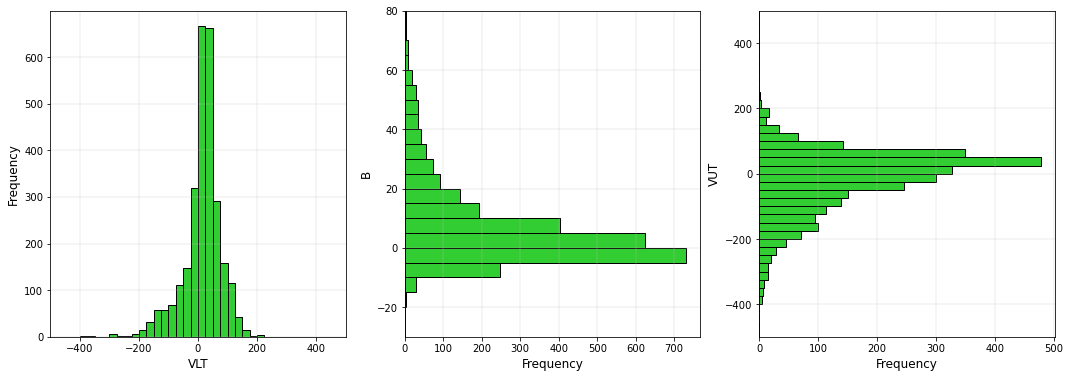

In [9]:
# Plot VLT Histogram
Fig = pyplot.figure(figsize=(18,6))
Axis = Fig.add_subplot(1,3,1)
Axis.hist(DF["VLT"], bins=numpy.arange(-500,525,25), color='limegreen', edgecolor='black')
Axis.set_xlim(-500,500)
Axis.set_xlabel('VLT', fontsize=12)
Axis.set_ylabel('Frequency', fontsize=12)
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Plot B Histogram
Axis = Fig.add_subplot(1,3,2)
Axis.hist(DF["B"], bins=numpy.arange(-30,85,5), color='limegreen', edgecolor='black', orientation='horizontal')
Axis.set_ylim(-30,80)
Axis.set_ylabel('B', fontsize=12)
Axis.set_xlabel('Frequency', fontsize=12)
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Plot VUT Histogram
Axis = Fig.add_subplot(1,3,3)
Axis.hist(DF["VUT"], bins=numpy.arange(-500,525,25), color='limegreen', edgecolor='black', orientation='horizontal')
Axis.set_ylim(-500,500)
Axis.set_ylabel('VUT', fontsize=12)
Axis.set_xlabel('Frequency', fontsize=12)
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [28]:
# Create Phase Space Distribution Bins
VLT_Bins = numpy.array([-500,-400,-300,-250,-200,-175,-150,-125,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,\
0,10,20,30,40,50,60,70,80,90,100,125,150,175,200,250,300,400,500])
B_Bins = numpy.array([-30,-25,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,\
25,30,35,40,45,50,60,70,80])
VUT_Bins = numpy.array([-500,-400,-300,-250,-200,-175,-150,-125,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,\
0,10,20,30,40,50,60,70,80,90,100,125,150,175,200,250,300,400,500])
VLT_Count = numpy.zeros(len(VLT_Bins)-1)
B_Count = numpy.zeros(len(B_Bins)-1)
VUT_Count = numpy.zeros(len(VUT_Bins)-1)
for i in range(len(DF["VLT"])):
    for j in range(len(VLT_Bins)-1):
        if DF["VLT"][i] > VLT_Bins[j] and DF["VLT"][i] <= VLT_Bins[j+1]:
            VLT_Count[j] += 1
    for k in range(len(B_Bins)-1):
        if DF["B"][i] > B_Bins[k] and DF["B"][i] <= B_Bins[k+1]:
            B_Count[k] += 1
    for l in range(len(VUT_Bins)-1):
        if DF["VUT"][i] > VUT_Bins[l] and DF["VUT"][i] <= VUT_Bins[l+1]:
            VUT_Count[l] += 1
print (VLT_Bins)
print (VLT_Count)
print (B_Bins)
print (B_Count)
print (VUT_Bins)
print (VUT_Count)

[-500 -400 -300 -250 -200 -175 -150 -125 -100  -90  -80  -70  -60  -50
  -40  -30  -20  -10    0   10   20   30   40   50   60   70   80   90
  100  125  150  175  200  250  300  400  500]
[  0.   2.   8.   7.  15.  32.  57.  58.  27.  24.  35.  48.  47.  43.
  60.  89.  98. 176. 206. 284. 335. 277. 227. 129. 119.  82.  70.  51.
 115.  42.  15.   2.   4.   0.   0.   0.]
[-30 -25 -20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10
  12  14  16  18  20  25  30  35  40  45  50  60  70  80]
[  0.   0.   0.   1.   4.   7.  21.  59. 108. 204. 272. 336. 291. 225.
 220. 164. 126.  84.  71.  81.  47.  54.  91.  74.  54.  42.  35.  35.
  49.  17.   6.]
[-500 -400 -300 -250 -200 -175 -150 -125 -100  -90  -80  -70  -60  -50
  -40  -30  -20  -10    0   10   20   30   40   50   60   70   80   90
  100  125  150  175  200  250  300  400  500]
[  0.  35.  35.  75.  70.  99.  94. 114.  51.  60.  49.  57.  71.  76.
 104. 128. 113. 124. 123. 128. 177. 195. 182. 154. 148.  85.  63.  42.
  66. 

In [29]:
# Calculate Phase Space Distribution Density
VLT_Density = numpy.zeros(len(VLT_Count))
B_Density = numpy.zeros(len(B_Count))
VUT_Density = numpy.zeros(len(VUT_Count))
VLT_Width = numpy.zeros(len(VLT_Count))
B_Width = numpy.zeros(len(B_Count))
VUT_Width = numpy.zeros(len(VUT_Count))
for i in range(len(DF["VLT"])):
    for j in range(len(VLT_Bins)-1):
        VLT_Width[j] = VLT_Bins[j+1] - VLT_Bins[j]
        VLT_Density[j] = VLT_Count[j] / VLT_Width[j]
    for k in range(len(B_Bins)-1):
        B_Width[k] = B_Bins[k+1] - B_Bins[k]
        B_Density[k] = B_Count[k] / B_Width[k]
    for l in range(len(VUT_Bins)-1):
        VUT_Width[l] = VUT_Bins[l+1] - VUT_Bins[l]
        VUT_Density[l] = VUT_Count[l] / VUT_Width[l]
print (VLT_Bins)
print (VLT_Density)
print (B_Bins)
print (B_Density)
print (VUT_Bins)
print (VUT_Density)

[-500 -400 -300 -250 -200 -175 -150 -125 -100  -90  -80  -70  -60  -50
  -40  -30  -20  -10    0   10   20   30   40   50   60   70   80   90
  100  125  150  175  200  250  300  400  500]
[0.00e+00 2.00e-02 1.60e-01 1.40e-01 6.00e-01 1.28e+00 2.28e+00 2.32e+00
 2.70e+00 2.40e+00 3.50e+00 4.80e+00 4.70e+00 4.30e+00 6.00e+00 8.90e+00
 9.80e+00 1.76e+01 2.06e+01 2.84e+01 3.35e+01 2.77e+01 2.27e+01 1.29e+01
 1.19e+01 8.20e+00 7.00e+00 5.10e+00 4.60e+00 1.68e+00 6.00e-01 8.00e-02
 8.00e-02 0.00e+00 0.00e+00 0.00e+00]
[-30 -25 -20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10
  12  14  16  18  20  25  30  35  40  45  50  60  70  80]
[  0.    0.    0.    0.5   2.    3.5  10.5  29.5  54.  102.  136.  168.
 145.5 112.5 110.   82.   63.   42.   35.5  40.5  23.5  27.   18.2  14.8
  10.8   8.4   7.    7.    4.9   1.7   0.6]
[-500 -400 -300 -250 -200 -175 -150 -125 -100  -90  -80  -70  -60  -50
  -40  -30  -20  -10    0   10   20   30   40   50   60   70   80   90
  100  125  150  17

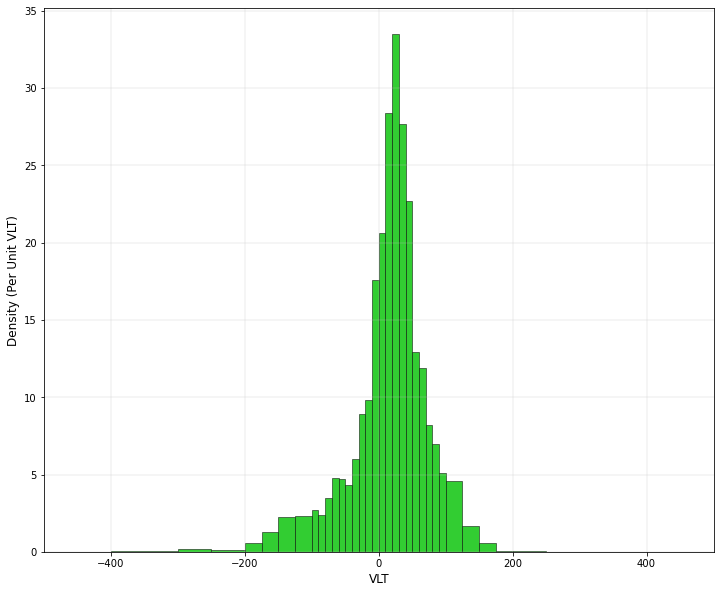

In [30]:
# Plot VLT Density Histogram
Fig = pyplot.figure(figsize=(12,10))
Axis = Fig.add_subplot(1,1,1)
Axis.bar(VLT_Bins[0:len(VLT_Bins)-1], VLT_Density, VLT_Width, align='edge', color='limegreen', \
edgecolor='black', linewidth=0.5)
Axis.set_xlim(-500,500)
Axis.set_xlabel('VLT', fontsize=12)
Axis.set_ylabel('Density (Per Unit VLT)', fontsize=12)
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

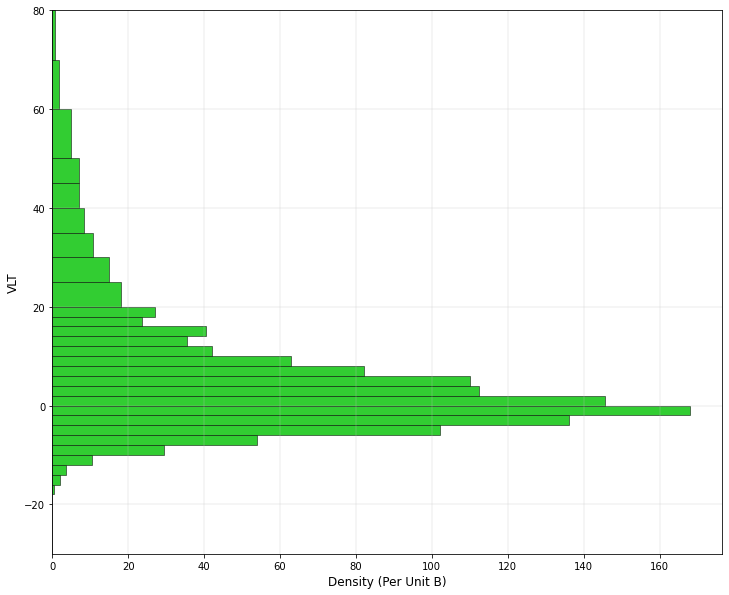

In [31]:
# Plot B Histogram
Fig = pyplot.figure(figsize=(12,10))
Axis = Fig.add_subplot(1,1,1)
Axis.barh(B_Bins[0:len(B_Bins)-1], B_Density, B_Width, align='edge', color='limegreen', \
edgecolor='black', linewidth=0.5)
Axis.set_ylim(-30,80)
Axis.set_ylabel('VLT', fontsize=12)
Axis.set_xlabel('Density (Per Unit B)', fontsize=12)
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

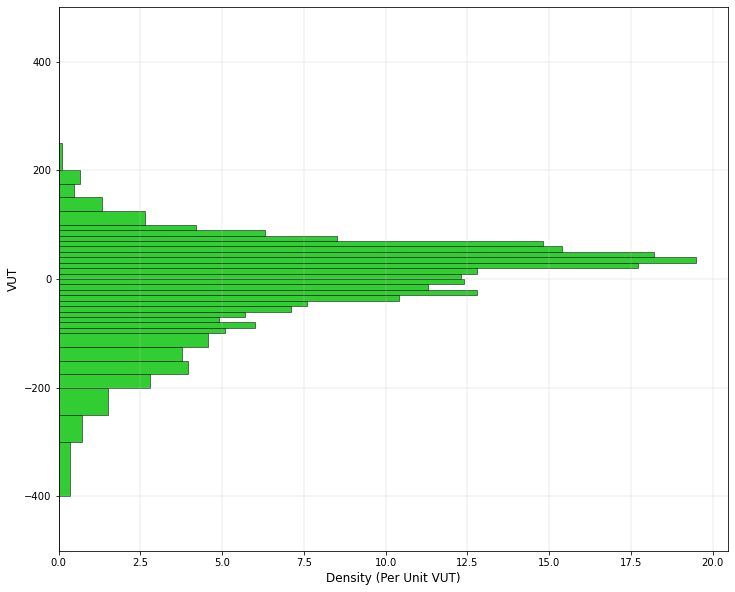

In [32]:
# Plot VUT Density Histogram
Fig = pyplot.figure(figsize=(12,10))
Axis = Fig.add_subplot(1,1,1)
Axis.barh(VUT_Bins[0:len(VUT_Bins)-1], VUT_Density, VUT_Width, align='edge', color='limegreen', \
edgecolor='black', linewidth=0.5)
Axis.set_ylim(-500,500)
Axis.set_ylabel('VUT', fontsize=12)
Axis.set_xlabel('Density (Per Unit VUT)', fontsize=12)
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [33]:
# Calculate VLT B Phase Space Distribution
VLT_B_Count = numpy.zeros((len(VLT_Bins)-1, len(B_Bins)-1))
for i in range(len(DF["VLT"])):
    for j in range(len(VLT_Bins)-1):
        if DF["VLT"][i] > VLT_Bins[j] and DF["VLT"][i] <= VLT_Bins[j+1]:
            for k in range(len(B_Bins)-1):
                if DF["B"][i] > B_Bins[k] and DF["B"][i] <= B_Bins[k+1]:
                    VLT_B_Count[j][k] += 1
VLT_B_Count

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 2., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
# Calculate Phase Space Distribution Density
VLT_B_Density = numpy.zeros((len(VLT_B_Count), len(VLT_B_Count[0])))
VLT_Width = numpy.zeros(len(VLT_Count))
B_Width = numpy.zeros(len(B_Count))
for i in range(len(DF["VLT"])):
    for j in range(len(VLT_B_Count)):
        VLT_Width[j] = VLT_Bins[j+1] - VLT_Bins[j]
        for k in range(len(VLT_B_Count[0])):
            B_Width[k] = B_Bins[k+1] - B_Bins[k]
            VLT_B_Density[j][k] = VLT_B_Count[j][k] / (VLT_Width[j] * B_Width[k])
#print (VLT_Bins)
#print (B_Bins)
print (VLT_B_Density)

[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.001 0.001]
 [0.    0.    0.    ... 0.    0.004 0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]


In [66]:
# Create Function For Colours
Colours = ['white', 'lightskyblue', 'deepskyblue', 'dodgerblue', 'darkcyan', 'lightseagreen', 'limegreen', \
'greenyellow', 'gold', 'darkorange', 'red']
Colour_Labels_B = ['0', '0~0.1', '0.1~0.25', '0.25~0.5', '0.5~0.75', '0.75~1', '1~1.5', \
'1.5~2', '2~2.5', '2.5~3', '>=3']
def Density_Colour_B(Density):
    if Density == 0:
        Colour = Colours[0]
    elif Density < 0.1:
        Colour = Colours[1]
    elif Density < 0.25:
        Colour = Colours[2]
    elif Density < 0.5:
        Colour = Colours[3]
    elif Density < 0.75:
        Colour = Colours[4]
    elif Density < 1:
        Colour = Colours[5]
    elif Density < 1.5:
        Colour = Colours[6]
    elif Density < 2:
        Colour = Colours[7]
    elif Density < 2.5:
        Colour = Colours[8]
    elif Density < 3:
        Colour = Colours[9]
    else:
        Colour = Colours[10]
    return (Colour)

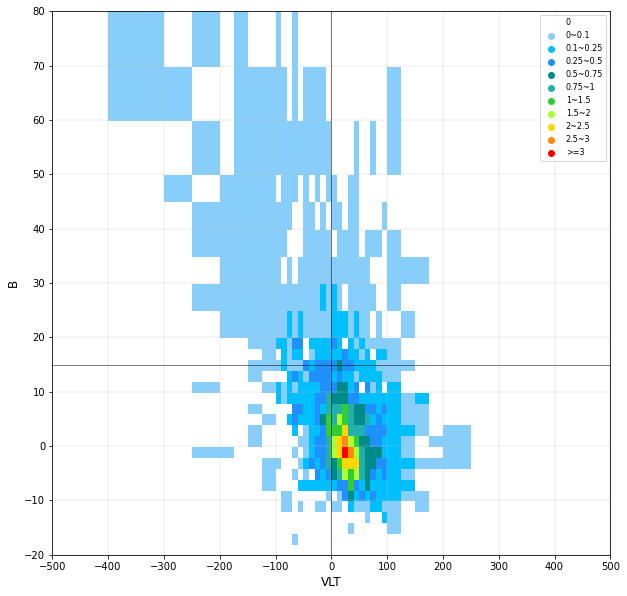

In [68]:
# Plot Cyclone Phase Distribution
Fig = pyplot.figure(figsize=(10,10))
Axis = Fig.add_subplot(1,1,1)
for j in range(len(VLT_B_Density)):
    for k in range(len(VLT_B_Density[0])):
#        print (VLT_B_Density[j][k])
        Colour = Density_Colour_B(VLT_B_Density[j][k])
#            print (Colour)
        pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
x_Axis = numpy.arange(-500,600,100)
y_Axis = numpy.arange(-20,90,10)
Axis.set_xticks(x_Axis)
Axis.set_yticks(y_Axis)
pyplot.xlim(-500,500)
pyplot.ylim(-20,80)
pyplot.plot([-500,500], [15,15], 'black', linewidth=0.5)
pyplot.plot([0,0], [-20,80], 'black', linewidth=0.5)
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
pyplot.xlabel('VLT', fontsize=12)
pyplot.ylabel('B', fontsize=12)
#
# Create Legend
for c in range(len(Colours)):
    pyplot.scatter([-728], [-728], c=Colours[c], label=Colour_Labels_B[c])
pyplot.legend(loc=1, fontsize=8)

In [55]:
# Calculate VLT VUT Phase Space Distribution
VLT_VUT_Count = numpy.zeros((len(VLT_Bins)-1, len(VUT_Bins)-1))
for i in range(len(DF["VLT"])):
    for j in range(len(VLT_Bins)-1):
        if DF["VLT"][i] > VLT_Bins[j] and DF["VLT"][i] <= VLT_Bins[j+1]:
            for l in range(len(VUT_Bins)-1):
                if DF["VUT"][i] > VUT_Bins[l] and DF["VUT"][i] <= VUT_Bins[l+1]:
                    VLT_VUT_Count[j][l] += 1
VLT_VUT_Count

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
# Calculate Phase Space Distribution Density
VLT_VUT_Density = numpy.zeros((len(VLT_VUT_Count), len(VLT_VUT_Count[0])))
VLT_Width = numpy.zeros(len(VLT_Count))
VUT_Width = numpy.zeros(len(VUT_Count))
for i in range(len(DF["VLT"])):
    for j in range(len(VLT_VUT_Count)):
        VLT_Width[j] = VLT_Bins[j+1] - VLT_Bins[j]
        for l in range(len(VLT_VUT_Count[0])):
            VUT_Width[l] = VUT_Bins[l+1] - VUT_Bins[l]
            VLT_VUT_Density[j][l] = VLT_VUT_Count[j][l] / (VLT_Width[j] * VUT_Width[l])
#print (VLT_Bins)
#print (B_Bins)
print (VLT_VUT_Density)

[[0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.001  0.0004 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]


In [59]:
# Create Function For Colours
Colours = ['white', 'lightskyblue', 'deepskyblue', 'dodgerblue', 'darkcyan', 'lightseagreen', 'limegreen', \
'greenyellow', 'gold', 'darkorange', 'red']
Colour_Labels_B = ['0', '0~0.01', '0.01~0.025', '0.025~0.05', '0.05~0.1', '0.10.15', '0.15~0.2', \
'0.2~0.3', '0.3~0.4', '0.4~0.5', '>=0.5']
def Density_Colour_VUT(Density):
    if Density == 0:
        Colour = 'white'
    elif Density < 0.01:
        Colour = 'lightskyblue'
    elif Density < 0.025:
        Colour = 'deepskyblue'
    elif Density < 0.05:
        Colour = 'dodgerblue'
    elif Density < 0.1:
        Colour = 'darkcyan'
    elif Density < 0.15:
        Colour = 'lightseagreen'
    elif Density < 0.2:
        Colour = 'limegreen'
    elif Density < 0.3:
        Colour = 'greenyellow'
    elif Density < 0.4:
        Colour = 'gold'
    elif Density < 0.5:
        Colour = 'orange'
    else:
        Colour = 'red'
    return (Colour)

Text(0, 0.5, 'VUT')

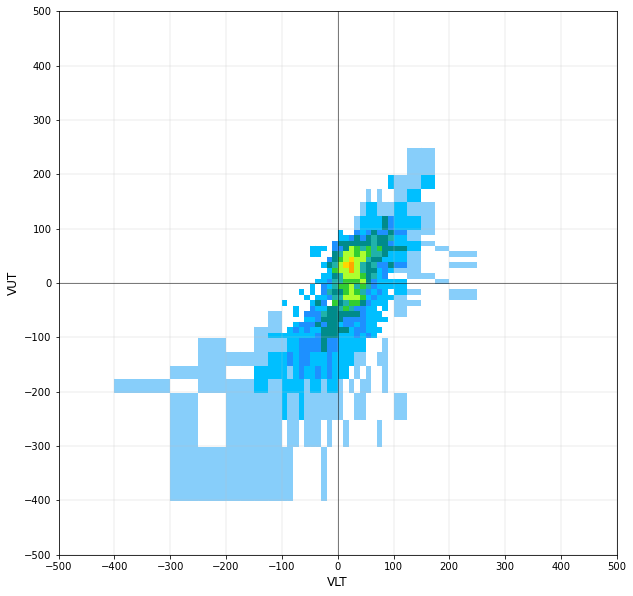

In [60]:
# Plot Cyclone Phase Distribution
Fig = pyplot.figure(figsize=(10,10))
Axis = Fig.add_subplot(1,1,1)
for j in range(len(VLT_VUT_Density)):
    for l in range(len(VLT_VUT_Density[0])):
#        print (VLT_B_Density[j][k])
        Colour = Density_Colour_VUT(VLT_VUT_Density[j][l])
#            print (Colour)
        pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VUT_Bins[l], VUT_Bins[l+1], color=Colour)
x_Axis = numpy.arange(-500,600,100)
y_Axis = numpy.arange(-500,600,100)
Axis.set_xticks(x_Axis)
Axis.set_yticks(y_Axis)
pyplot.xlim(-500,500)
pyplot.ylim(-500,500)
pyplot.plot([-500,500], [0,0], 'black', linewidth=0.5)
pyplot.plot([0,0], [-500,500], 'black', linewidth=0.5)
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
pyplot.xlabel('VLT', fontsize=12)
pyplot.ylabel('VUT', fontsize=12)
#
# Create Legend
for c in range(len(Colours)):
    pyplot.scatter([-728], [-728], c=Colours[c], label=Colour_Labels_VUT[c])
pyplot.legend(loc=1, fontsize=8)